# Reproduction of Fig. 5 and Fig. S6

In [1]:
import numpy as np
import pandas as pd
from Bio.Seq import reverse_complement
from collections import Counter
from functools import partial
from itertools import product, chain
from tqdm.notebook import tqdm
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.genomeutil import sliding
metadata = Metadata()

In [2]:
standard = {
    'TTT': 'F', 'TCT': 'S', 'TAT': 'Y', 'TGT': 'C',
    'TTC': 'F', 'TCC': 'S', 'TAC': 'Y', 'TGC': 'C',
    'TTA': 'L', 'TCA': 'S', 'TAA': '*', 'TGA': '*',
    'TTG': 'L', 'TCG': 'S', 'TAG': '*', 'TGG': 'W',
    'CTT': 'L', 'CCT': 'P', 'CAT': 'H', 'CGT': 'R',
    'CTC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
    'CTA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R',
    'CTG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',
    'ATT': 'I', 'ACT': 'T', 'AAT': 'N', 'AGT': 'S',
    'ATC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
    'ATA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R',
    'ATG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',
    'GTT': 'V', 'GCT': 'A', 'GAT': 'D', 'GGT': 'G',
    'GTC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
    'GTA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G',
    'GTG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G',    
}

In [3]:
def custom_translate(seq, tbl):
    return ''.join([tbl[c] for c in sliding(seq, 3, 3)])

std_translate = partial(custom_translate, tbl=standard)

In [4]:
bicodons_summary = pd.read_pickle(path2.data/'kmer'/'bicodons_summary.pkl.bz2')
codons_summary = pd.read_pickle(path2.data/'kmer'/'codons_summary.pkl.bz2')
nts_summary = pd.read_pickle(path2.data/'kmer'/'nts_summary.pkl.bz2')

In [5]:
GCsummary = nts_summary.T.eval('(C+G) / (A+C+G+T)')
AAsummary = codons_summary.groupby(std_translate).sum()
biAAsummary = bicodons_summary.groupby(std_translate).sum()

In [6]:
meanGC = GCsummary.mean()
AA_meanGC = AAsummary.T.mean()
biAA_meanGC = biAAsummary.T.mean()

highGC = GCsummary[GCsummary >= meanGC].mean()
AA_highGC = AAsummary.T.loc[GCsummary >= meanGC].mean()
biAA_highGC = biAAsummary.T.loc[GCsummary >= meanGC].mean()


lowGC = GCsummary[GCsummary < meanGC].mean()
AA_lowGC = AAsummary.T.loc[GCsummary < meanGC].mean()
biAA_lowGC  = biAAsummary.T.loc[GCsummary < meanGC].mean()

highGC, meanGC, lowGC

(0.6405974922021773, 0.5305268588257096, 0.4097219190767952)

In [7]:
(GCsummary < meanGC).sum(), (GCsummary >= meanGC).sum(),

(1251, 1373)

In [8]:
def HH91(N, fix_stop=True, seed=None): 
    np.random.seed(seed)
    AAs = [*'ACDEFGHIKLMNPQRSTVWY'] if fix_stop else [*'ACDEFGHIKLMNPQRSTVWY*']
    for _ in range(N):
        AAmap = {'*': '*'}
        AAmap.update(dict(zip(AAs, np.random.permutation(AAs))))
        random_code = {k: AAmap[v] for k, v in standard.items()}
        yield random_code

In [9]:
codons = [*map(''.join, product('ACGT', repeat=3))]
bicodons = [*map(''.join, product('ACGT', repeat=6))]

In [10]:
topidp = pd.Series(dict(
    W = -0.884, F = -0.697, Y = -0.510, I = -0.486, 
    M = -0.397, L = -0.326, V = -0.121, N = +0.007, 
    C = +0.020, T = +0.059, A = +0.060, G = +0.166, 
    R = +0.180, D = +0.192, H = +0.302, Q = +0.318,
    S = +0.341, K = +0.586, E = +0.736, P = +0.987,
))

In [11]:
def get_idp_stats(rand_code, mode):
    weight_gc, freq_AA, freq_biAA = dict(
        highGC = (highGC, AA_highGC, biAA_highGC),
        meanGC = (meanGC, AA_meanGC, biAA_meanGC),
        lowGC  = (lowGC , AA_lowGC , biAA_lowGC )
    )[mode]
    rand_transl = lambda seq: custom_translate(seq, rand_code)
    
    gc_codon = pd.DataFrame(map(Counter, codons), index=codons).fillna(0)
    weight_codon = gc_codon.eval(f'{1-weight_gc}**(A+T) * {weight_gc}**(G+C)')
    codon_usage = weight_codon / weight_codon.groupby(rand_transl).transform('sum')
    
    gc_bicodon = pd.DataFrame(map(Counter, bicodons), index=bicodons).fillna(0)
    weight_bicodon = gc_bicodon.eval(f'{1-weight_gc}**(A+T) * {weight_gc}**(G+C)')
    bicodon_usage = weight_bicodon / weight_bicodon.groupby(rand_transl).transform('sum')
    
    est_codons = pd.Series({
        c: codon_usage.loc[c] * freq_AA.loc[rand_transl(c)]
        for c in codons
    })
    est_bicodons = pd.Series({
        bc: bicodon_usage.loc[bc] * freq_biAA.loc[rand_transl(bc)]
        for bc in bicodons
    })
    
    fw1 = lambda bc: rand_code[bc[1:4]]
    fw2 = lambda bc: rand_code[bc[2:5]]
    rc1 = lambda bc: rand_code[reverse_complement(bc[1:4])]
    rc2 = lambda bc: rand_code[reverse_complement(bc[2:5])]
    
    stats = pd.Series(dtype=float)
    for frame, arf in zip(['+1','+2','-1','-2'], [fw1, fw2, rc1, rc2]):
        est_arfAA = est_bicodons.groupby(arf).sum().drop('*')
        stats[frame] = topidp @ (est_arfAA / est_arfAA.sum())

    rc0 = lambda c: rand_code[reverse_complement(c)]
    est_arfAA = est_codons.groupby(rc0).sum().drop('*')
    stats['-0'] = topidp @ (est_arfAA / est_arfAA.sum())
    
    tmp_fw2 = est_bicodons.groupby(fw2).sum().drop('*')
    tmp_rc1 = est_bicodons.groupby(rc1).sum().drop('*')
    stats['+2/-1'] = topidp @ (tmp_fw2 + tmp_rc1) / (tmp_fw2 + tmp_rc1).sum()
    return stats

def get_idp_stats_highGC(rand_code): return get_idp_stats(rand_code, 'highGC')
def get_idp_stats_meanGC(rand_code): return get_idp_stats(rand_code, 'meanGC')
def get_idp_stats_lowGC(rand_code) : return get_idp_stats(rand_code, 'lowGC' )

from multiprocessing import Pool
with Pool(100) as pool:
    simulated_stats_highGC = pd.concat(
        tqdm(pool.imap_unordered(get_idp_stats_highGC, HH91(100000, fix_stop=True, seed=831)), total=100000), 
        axis=1
    )
    simulated_stats_meanGC = pd.concat(
        tqdm(pool.imap_unordered(get_idp_stats_meanGC, HH91(100000, fix_stop=True, seed=831)), total=100000), 
        axis=1
    )
    simulated_stats_lowGC  = pd.concat(
        tqdm(pool.imap_unordered(get_idp_stats_lowGC , HH91(100000, fix_stop=True, seed=831)), total=100000), 
        axis=1
    )
real_stats_highGC = get_idp_stats_highGC(standard)
real_stats_meanGC = get_idp_stats_meanGC(standard)
real_stats_lowGC  = get_idp_stats_lowGC(standard)


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

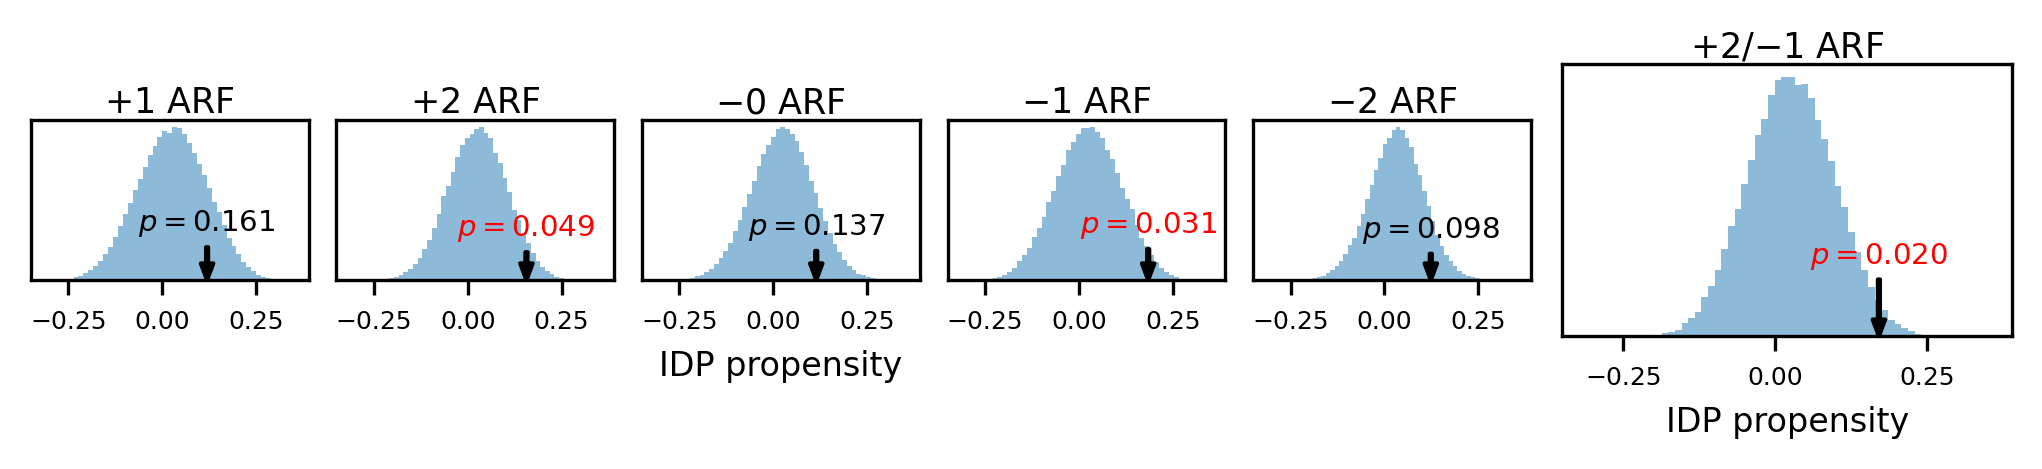

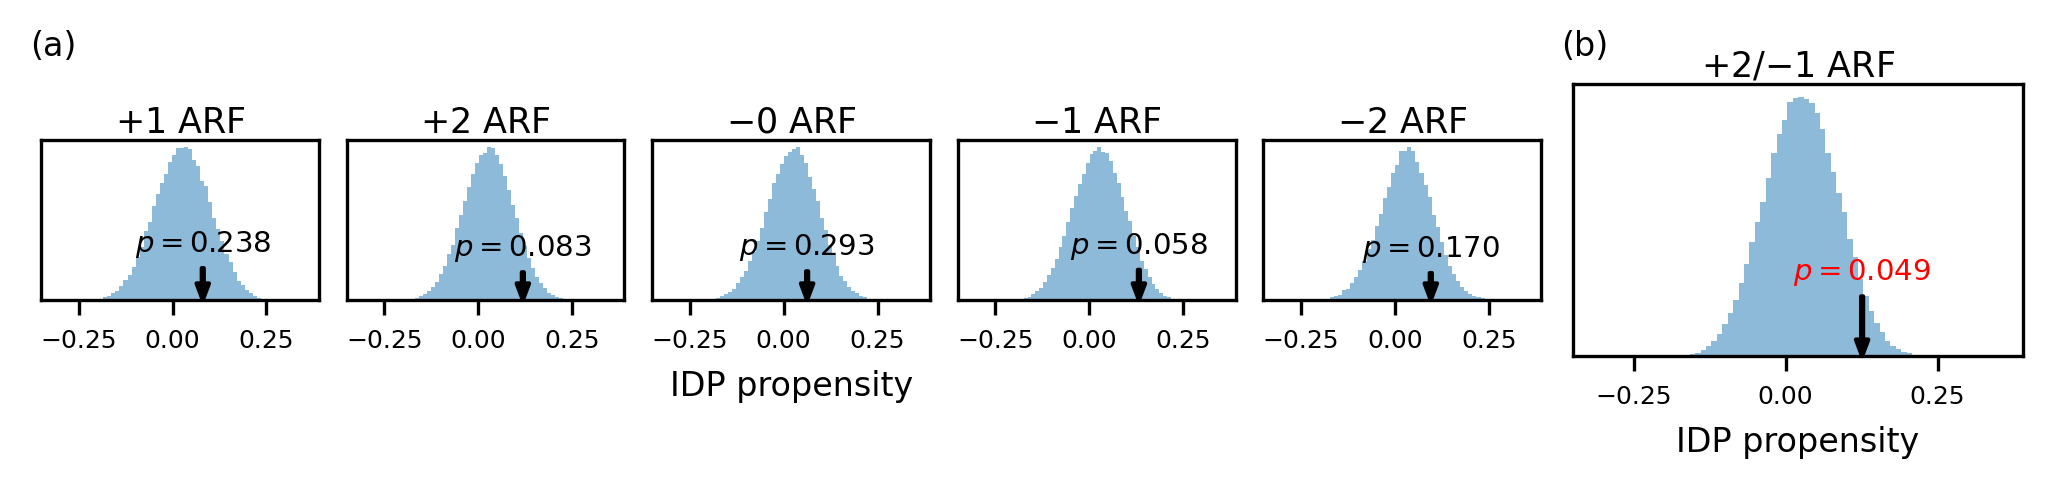

In [30]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

mm = 1 / 25.4

with plt.rc_context({'font.size': 7, 'xtick.labelsize': 6, 'ytick.labelsize': 6}):
    annotate_kw = dict(arrowprops=dict(fc='k', shrink=0, width=0.5, headlength=4, headwidth=3), ha='center', va='bottom')
    
    for real_stats, simulated_stats, ylabel, figname in zip(
        [real_stats_highGC, real_stats_meanGC, real_stats_lowGC], 
        [simulated_stats_highGC, simulated_stats_meanGC, simulated_stats_lowGC],
        ['high GC%', 'mean GC%', 'low GC%'],
        ['Fig5bc', 'FigS6']
    ):
        
        #fig, axes = plt.subplots(1, 6, figsize=(174*mm, 35*mm), sharex=True, sharey=True, dpi=300)
        fig = plt.figure(figsize=(174*mm, 40*mm), dpi=300)

        # Layout
        gs = GridSpec(1, 2, width_ratios=[5, 1.5])
        gs1  = GridSpecFromSubplotSpec(3, 5, subplot_spec=gs[0, 0], height_ratios=[1/6,2/3,1/6], wspace=0.1)
        gs2  = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1])

        for frame, g in zip(['+1','+2','-0','-1','-2','+2/-1'], [gs1[1,0],gs1[1,1],gs1[1,2],gs1[1,3],gs1[1,4],gs2[0,0]]):
            ax = fig.add_subplot(g)
            simulated_stats.T[frame].plot.hist(bins=50, alpha=0.5, ax=ax)
            x = real_stats[frame]
            p = (simulated_stats.T[frame] > x).mean()
            ax.annotate(f'${p=:.03f}$', (x, 0),  (x, 1500), c='red' if p<0.05 else 'k', **annotate_kw)
            ax.set_title(f'${frame.replace("/","$/$")}$ ARF', pad=1)
            ax.set_xlim(-0.35, 0.39)
            ax.set_ylabel(None)
            ax.yaxis.set_tick_params(left=False, labelleft=False)
            
            if frame in ['-0', '+2/-1']:
                ax.set_xlabel('IDP propensity', fontsize=8)
        fig.tight_layout()
        if figname == 'FigS6':
            fig.text(0.015, 0.92, '(a)', fontsize=8)
            fig.text(0.76, 0.92, '(b)', fontsize=8)
        if figname: 
            fig.patch.set_facecolor('none')
            fig.savefig(f'./Figs/{figname}.pdf')
            fig.patch.set_facecolor('w')
            fig.savefig(f'./Figs/{figname}.tif')

In [14]:
table = [
    [f'{f}{s}{t}' for s in 'TCAG']
    for f in 'TCAG' for t in 'TCAG'
]

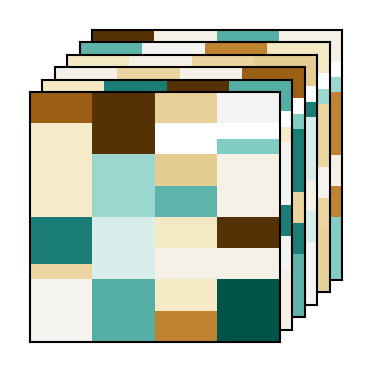

In [14]:
mm = 1 / 25.4

with plt.rc_context({
    'xtick.bottom': False, 'xtick.labelbottom': False, 'ytick.left': False, 'ytick.labelleft': False,
    'axes.linewidth': 0.5,
}):
    fig, ax = plt.subplots(figsize=(35*mm, 35*mm), dpi=300)
    [sp.set_visible(False) for sp in ax.spines.values()]
    for i, shuffled in enumerate(HH91(6, fix_stop=True, seed=831)):
        inax = ax.inset_axes([0.04*(5-i), 0.04*(5-i), 0.8, 0.8])
        im = inax.imshow([
            [topidp.get(shuffled[cdn], np.nan) for cdn in row]
            for row in table
        ], cmap='BrBG_r', vmax=1, vmin=-1)
        inax.set_aspect(0.25)
    ax.set_aspect('equal')
    ax.set_facecolor('None')
    fig.savefig('./Figs/Fig5a-sub1.pdf')

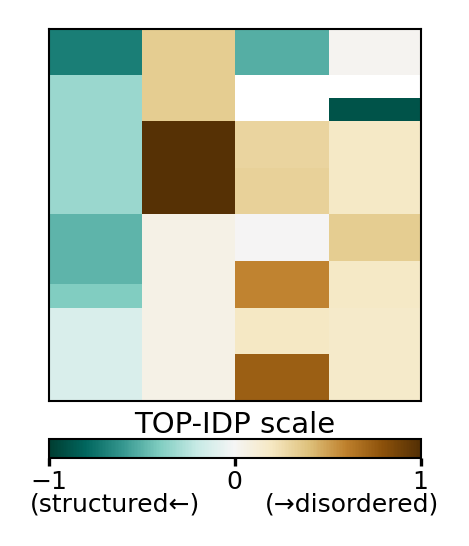

In [148]:
mm = 1 / 25.4

with plt.rc_context({
    'xtick.bottom': False, 'xtick.labelbottom': False, 'ytick.left': False, 'ytick.labelleft': False,
    'axes.linewidth': 0.5, 'font.size': 6
}):
    fig, ax = plt.subplots(figsize=(35*mm, 42*mm), dpi=300)#, gridspec_kw=dict(height_ratios=[29, 1], hspace=0))
    im = ax.imshow([
        [topidp.get(standard[cdn], np.nan) for cdn in row]
        for row in table
    ], cmap='BrBG_r', vmax=1, vmin=-1)
    ax.set_aspect(0.25)
    ax.set_facecolor('w')
    
    fig.subplots_adjust(left=0.05, right=0.95, top=1, bottom=0.22)
    
    cax = fig.add_axes([0.05, 0.12, 0.9, 0.04])
    #cax.set_ylabel('TOP-IDP scale', rotation=0, va='center', ha='center', labelpad=24.5)
    #cax.text(0, 0, 'IDP', va='center', ha='center')
    cbar = fig.colorbar(im, cax=cax, fraction=0.1, orientation='horizontal')
    cax.text(-1.1, -5.6, '(structured←)', ha='left', va='center', size=6)
    cax.text( 1.1, -5.6, '(→disordered)', ha='right', va='center', size=6)
    cax.set_title('TOP-IDP scale', size=7, pad=0)
    cax.xaxis.set_major_locator(plt.MultipleLocator(1))
    cax.xaxis.set_tick_params(length=2, pad=0.5)
    fig.savefig('./Figs/Fig5a-sub2.pdf')